In [ ]:
import requests
import pandas as pd
from datetime import datetime

In [8]:


def fetch_noaa_data(api_token, datasetid, datatypeids, locationid, startdate, enddate, units='standard', limit=1000):
    url = 'https://www.ncdc.noaa.gov/cdo-web/api/v2/data'
    headers = {'token': api_token}
    params = {
        'datasetid': datasetid,
        'datatypeid': ','.join(datatypeids),  # Join multiple datatypeids with commas
        'locationid': locationid,
        'startdate': startdate,
        'enddate': enddate,
        'units': units,
        'limit': limit,
        'offset': 1
    }
    
    all_data = []
    
    while True:
        response = requests.get(url, headers=headers, params=params)
        if response.status_code == 200:
            data = response.json().get('results', [])
            if not data:
                break
            all_data.extend(data)
            params['offset'] += limit
        else:
            print(f"Error: {response.status_code} - {response.text}")
            break
    
    df = pd.DataFrame(all_data)
    
    if not df.empty:
        df['date'] = pd.to_datetime(df['date'])
        df = df.pivot_table(index='date', columns='datatype', values='value', aggfunc='mean').reset_index()
    
    return df

# Usage
datatypeids = ['TMAX', 'TMIN', 'AWND', 'PRCP', 'SNOW', 'TSUN', 'RH']
df = fetch_noaa_data(
    api_token='TtxpQKnROSmRUxTNtKTNWVSLASLGVUNl',
    datasetid='GHCND',
    datatypeids=datatypeids,
    locationid='FIPS:27',  # New York State (use appropriate FIPS code for your region)
    startdate='2024-06-27',
    enddate='2024-08-05'
)

df.to_csv('noaa_weather_data.csv', index=False)
print("Data has been saved to noaa_weather_data.csv")



Data has been saved to noaa_weather_data.csv


In [2]:
import requests
import pandas as pd
from datetime import datetime

# Your NOAA API token
API_TOKEN = 'TtxpQKnROSmRUxTNtKTNWVSLASLGVUNl'

# API endpoint for daily summaries
url = 'https://www.ncdc.noaa.gov/cdo-web/api/v2/data'

# Parameters for the API request
params = {
    'datasetid': 'GHCND',  # Daily summaries dataset
    'datatypeid': 'TMAX',  # Maximum temperature
    'locationid': 'FIPS:27',  # New York State (use FIPS codes for other regions)
    'startdate': '2024-06-27',
    'enddate': '2024-07-26',
    'units': 'standard',  # 'standard' for Fahrenheit, 'metric' for Celsius
    'limit': 1000,  # Number of records to fetch (max 1000 per request)
}

# Headers for the API request
headers = {
    'token': API_TOKEN
}

# Make the API request
response = requests.get(url, headers=headers, params=params)

# Check if the request was successful
if response.status_code == 200:
    data = response.json()['results']
    # Convert the data to a DataFrame
    df = pd.DataFrame(data)
    print(df)
else:
    print(f"Error: {response.status_code} - {response.text}")

                    date datatype            station attributes  value
0    2024-06-27T00:00:00     TMAX  GHCND:USC00210018   ,,7,0700   66.0
1    2024-06-27T00:00:00     TMAX  GHCND:USC00210075   ,,7,0800   79.0
2    2024-06-27T00:00:00     TMAX  GHCND:USC00210287   ,,7,1800   71.0
3    2024-06-27T00:00:00     TMAX  GHCND:USC00210355   ,,H,0700   79.0
4    2024-06-27T00:00:00     TMAX  GHCND:USC00210515   ,,7,0700   89.0
..                   ...      ...                ...        ...    ...
995  2024-07-03T00:00:00     TMAX  GHCND:USC00219046   ,,H,0800   73.0
996  2024-07-03T00:00:00     TMAX  GHCND:USC00219072   ,,H,0830   68.0
997  2024-07-03T00:00:00     TMAX  GHCND:USC00219170   ,,W,0700   83.0
998  2024-07-03T00:00:00     TMAX  GHCND:USC00219173   ,,H,0600   69.0
999  2024-07-03T00:00:00     TMAX  GHCND:USC00219249   ,,H,0700   68.0

[1000 rows x 5 columns]


## Growth Rate Analysis

In [1]:
import matplotlib.pylab as plt
import numpy as np
import sklearn as sk
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def r2_score(y_true, y_pred):
    # Calculate the mean of the true target values
    y_mean = np.mean(y_true)
    
    # Calculate the total sum of squares (TSS)
    tss = np.sum((y_true - y_mean) ** 2)
    
    # Calculate the residual sum of squares (RSS)
    rss = np.sum((y_true - y_pred) ** 2)
    
    # Calculate R^2 score
    r2 = 1 - (rss / tss)
    
    return r2


#Load the CSV file
data = pd.read_csv('Data_EV_Grow.csv')


def Create_data(y_var,x_vars, one_hot=False):

    #Prepare the data
    X = data.drop(columns=x_vars)
    y = data[y_var]  # Dependent variable
    X = X.drop(columns=['State'])
    X = X.drop(columns=['Land area in square miles, 2010'])
    X = X.drop(columns=['All employer firms per capita, Reference year 2017'])
    X = X.drop(columns=['Total Chargers Chargers'])
    X = X.drop(columns=['Population estimates, July 1, 2023, (V2023)'])
    X = X.drop(columns=['Population per square mile, 2010'])    
    X = X.drop(columns=['1-YR Growth Rate 2022'])
    X = X.drop(columns=['2-YR Growth Rate 2022'])
    X = X.drop(columns=['Number of Evs per capita 2022'])
    X = X.drop(columns=['Number of Evs 2022'])
    
    if one_hot == False:
        return X, y
    else:
        encoder = OneHotEncoder(sparse=False)

        one_hot_encoded = encoder.fit_transform(data[['Political Affiliation']])
        feature_names = encoder.categories_[0]
        one_hot_encoded_df = pd.DataFrame(one_hot_encoded, columns=feature_names)
        X = pd.concat([X, one_hot_encoded_df], axis=1)
        X = X.drop(columns=['Political Affiliation'])
        X = X.drop(columns=['Red'])

        return X, y

def run_linear_regression(X, y):
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    # Create and fit linear regression model
    model = LinearRegression()
    model.fit(X_train, y_train)
    # Evaluate model on train set
    train_r2 = r2_score(y_train, model.predict(X_train))
    # Evaluate model on test set
    test_r2 = r2_score(y_test, model.predict(X_test))
    return model, train_r2, test_r2

def remove_feature_with_smallest_contribution(X, y, model):
    # Get coefficients
    coefficients = model.coef_
    # Find index of feature with smallest coefficient magnitude
    feature_to_remove_index = np.argmin(np.abs(coefficients))
    # Remove feature with smallest coefficient magnitude
    X_updated = np.delete(X, feature_to_remove_index, axis=1)
    return X_updated




In [2]:
"""
X Values
Auto sales per capita 2023	
Number of Evs per capita 2018	
Number of Evs per capita 2019	
Number of Evs per capita 2020	
Number of EVs per capita 2021	
Number of Evs per capita 2022	
Auto sales 2023	
Number of Evs 2018	
Number of Evs 2019	
Number of Evs 2020	
Number of EVs 2021	
Number of Evs 2022	
1-YR Growth Rate 2019
1-YR Growth Rate 2020
1-YR Growth Rate 2021

y Values
1-YR Growth Rate 2022	
2-YR Growth Rate 2022


x_vars =['Auto sales per capita 2023','Number of Evs per capita 2018','Number of Evs per capita 2019','Number of Evs per capita 2020','Number of EVs per capita 2021','Number of Evs per capita 2022','Auto sales 2023','Number of Evs 2018','Number of Evs 2019','Number of Evs 2020','Number of EVs 2021','Number of Evs 2022',['Auto sales 2023','Number of Evs 2018','Number of Evs 2019','Number of Evs 2020','Number of EVs 2021','Number of Evs 2022','1-YR Growth Rate 2019','1-YR Growth Rate 2020','1-YR Growth Rate 2021']]
y_var = '1-YR Growth Rate 2022'
y_var = '2-YR Growth Rate 2022'


"""
x_vars = [[],
          ['Auto sales 2023','Number of Evs 2018','Number of Evs 2019','Number of Evs 2020','Number of EVs 2021','1-YR Growth Rate 2019','1-YR Growth Rate 2020','1-YR Growth Rate 2021'],
          ['Auto sales per capita 2023','Number of Evs per capita 2018','Number of Evs per capita 2019','Number of Evs per capita 2020','Number of EVs per capita 2021','1-YR Growth Rate 2019','1-YR Growth Rate 2020','1-YR Growth Rate 2021'],
          ['Auto sales 2023','Number of Evs 2018','Number of Evs 2019','Number of Evs 2020','Number of EVs 2021','1-YR Growth Rate 2019','1-YR Growth Rate 2020','1-YR Growth Rate 2021'],
          ['Auto sales per capita 2023','Number of Evs per capita 2018','Number of Evs per capita 2019','Number of Evs per capita 2020','Number of EVs per capita 2021','1-YR Growth Rate 2019','1-YR Growth Rate 2020','1-YR Growth Rate 2021'],
          ['Auto sales 2023','Number of Evs 2018','Number of Evs 2019','Number of Evs 2020','Number of EVs 2021','1-YR Growth Rate 2019','1-YR Growth Rate 2020','1-YR Growth Rate 2021','Auto sales per capita 2023','Number of Evs per capita 2018','Number of Evs per capita 2019','Number of Evs per capita 2020'],
          ['Auto sales 2023','Number of Evs 2018','Number of Evs 2019','Number of Evs 2020','1-YR Growth Rate 2019','1-YR Growth Rate 2020','1-YR Growth Rate 2021','Auto sales per capita 2023','Number of Evs per capita 2018','Number of Evs per capita 2019','Number of Evs per capita 2020','Number of EVs per capita 2021'],
          ['Auto sales 2023','Number of Evs 2018','Number of Evs 2019','Number of Evs 2020','Number of EVs 2021','Auto sales per capita 2023','Number of Evs per capita 2018','Number of Evs per capita 2019','Number of Evs per capita 2020','Number of EVs per capita 2021'],
          ['Auto sales 2023','Number of Evs 2018','Number of Evs 2019','Number of Evs 2020','Number of EVs 2021','Auto sales per capita 2023','Number of Evs per capita 2018','Number of Evs per capita 2019','Number of Evs per capita 2020','Number of EVs per capita 2021','1-YR Growth Rate 2019','1-YR Growth Rate 2020'],
          ['Auto sales 2023','Number of Evs 2018','Number of Evs 2019','Number of Evs 2020','Number of EVs 2021','Auto sales per capita 2023','Number of Evs per capita 2018','Number of Evs per capita 2019','Number of Evs per capita 2020','Number of EVs per capita 2021','1-YR Growth Rate 2019','1-YR Growth Rate 2021'],
          ['Auto sales 2023','Number of Evs 2018','Number of Evs 2019','Number of Evs 2020','Number of EVs 2021','Auto sales per capita 2023','Number of Evs per capita 2018','Number of Evs per capita 2019','Number of Evs per capita 2020','Number of EVs per capita 2021','1-YR Growth Rate 2020','1-YR Growth Rate 2021']
]
#1. All Variables
#2. per capita
#3. total count
#4. just current year per capita EV and auto sales
#5. just current year total count EV and auto sales
#6. just current year per capita EV
#7. just current year total count EV
#8. drop all but the growth rates
#9. drop all but the growth rate 2021
#10. Drop all but growth rate 2020
y_var = ['1-YR Growth Rate 2022', '2-YR Growth Rate 2022']

for y_it in y_var:
    i=0
    for x_it in x_vars:
        i+=1
        X,y = Create_data(y_it, x_it, True)

        #Scale X
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        #Scale y
        scaler = StandardScaler()
        y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))


        model, train_r2, test_r2 = run_linear_regression(X_scaled, y_scaled)

        # Print coefficients of initial regression
        print(f"______Model: X_scenario {i} -> {y_it}______")
        print("Initial coefficients:", model.coef_)
        print("Initial train R2:", train_r2)
        print("Initial test R2:", test_r2)

c:\Users\fenst\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\fenst\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\fenst\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\fenst\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocess

______Model: X_scenario 1 -> 1-YR Growth Rate 2022______
Initial coefficients: [[-4.70542092e+00  7.52003030e+00  4.25473807e+00  4.94854509e+00
  -4.73440960e+00  2.20635688e+00  2.74093744e+00 -3.75457566e+00
   1.42972482e+00 -4.97975064e+00  7.37422336e+00  1.02566200e-01
   2.14251190e+00  8.15278775e+00  3.41602828e+00 -4.52584386e+00
   1.88998779e+00 -7.01247137e+00  2.14674063e+00 -1.81039247e+00
  -6.37216120e+00  2.20636017e+00 -3.57266134e+00  1.57799450e+00
   2.76630110e+00 -2.97459653e+07 -3.08047101e+06  7.33292172e+05
   5.02537756e+06 -2.25528378e+06  2.97459674e+07  3.08051393e+06
  -7.33346155e+05 -5.02542311e+06  2.25533869e+06  3.44077234e+00
  -5.69746991e-02 -3.28768635e+00 -3.15775156e-01]]
Initial train R2: 0.9999999999999999
Initial test R2: -86.07531647051071
______Model: X_scenario 2 -> 1-YR Growth Rate 2022______
Initial coefficients: [[-0.34780828  0.0093437   0.4426924  -0.06094789 -0.20504342  0.28859054
  -0.42116428 -0.0147845   0.06823389 -0.12858231

c:\Users\fenst\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\fenst\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\fenst\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\fenst\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocess

______Model: X_scenario 7 -> 1-YR Growth Rate 2022______
Initial coefficients: [[ 0.3265031  -0.52173978  0.79821766 -0.59304724 -0.04397081  0.026876
  -2.10308701  1.05793383  0.00801313  0.00405721  0.06924754 -0.38214929
  -0.10935375  0.25243741 -0.28790251  0.40352147  0.5284114   0.20149878
   1.02938503  0.36810556  0.58832202 -0.45261197  0.5022824  -0.67045589
   0.24268807  0.68859105  0.42046099]]
Initial train R2: 0.7952839670337918
Initial test R2: -4.911945561572116
______Model: X_scenario 8 -> 1-YR Growth Rate 2022______
Initial coefficients: [[-0.25503639 -0.5848629   0.61433293 -0.27441436 -0.27777756  0.39416252
  -0.33164449  0.10966342  0.49892843  0.71025868 -0.10635059 -0.69702762
   0.32624368  0.38367121 -0.13953166  0.42714545 -0.88531536  0.03802518
  -0.11531541 -0.36642256  0.0933752  -0.02651943  0.25702508 -0.32050061
   0.22820133 -0.21785905 -0.07173601  0.66187765  0.13896282]]
Initial train R2: 0.9175781818847212
Initial test R2: -2.192299070454213
__

c:\Users\fenst\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\fenst\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\fenst\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\fenst\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocess

______Model: X_scenario 4 -> 2-YR Growth Rate 2022______
Initial coefficients: [[ -0.27511055   0.2810647    0.09705344   0.23025075   0.16494233
    0.11902646  -0.14200663  -0.02426842  -0.25916484  -0.60835865
    0.52473426  -0.28252879  -0.6635793    0.2207394    0.10890406
   -0.30421911   1.43305047  -0.38303858   0.46811614  -0.14948215
   -0.06674109   0.46585384  -0.11411365  -0.17350383   0.29758191
    0.39009935   0.74909851   2.87418411 -11.37329887   7.38897477
    0.22966505]]
Initial train R2: 0.9532500026262998
Initial test R2: -0.8540232534125023
______Model: X_scenario 5 -> 2-YR Growth Rate 2022______
Initial coefficients: [[ -0.2751039    0.28106151   0.09705167   0.23024966   0.16494205
    0.11902622  -0.14201364  -0.02427594  -0.25916296  -0.60835795
    0.52473388  -0.28252848  -0.66356843   0.22073401   0.10890428
   -0.30421469   1.43307063  -0.38306277   0.4681209   -0.14948039
   -0.06673804   0.46584506  -0.11411674  -0.17350229   0.2975836
    0.39009562 

c:\Users\fenst\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\fenst\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
c:\Users\fenst\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [3]:
#create data set using only the values of X in x_vars
X = data[['Number of Evs per capita 2018','Number of Evs per capita 2019','Number of Evs per capita 2020','Number of EVs per capita 2021','Number of Evs 2018','Number of Evs 2019','Number of Evs 2020','Number of EVs 2021','1-YR Growth Rate 2019','1-YR Growth Rate 2020','1-YR Growth Rate 2021']]
#predict 1 year growth rate
y = data[y_var[0]]

#Scale X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Scale y
scaler = StandardScaler()
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

#run linear regression
model, train_r2, test_r2 = run_linear_regression(X_scaled, y_scaled)
# Print coefficients of initial regression
print("Initial coefficients:", model.coef_)
print("Initial train R2:", train_r2)
print("Initial test R2:", test_r2)



Initial coefficients: [[ 7.31632795e+04 -2.72788520e+05 -9.84559857e+05 -2.82661701e+05
  -7.31600955e+04  2.72787197e+05  9.84552850e+05  2.82666758e+05
  -1.58507849e-02  2.46724249e-01  3.59147673e-01]]
Initial train R2: 0.6807051662744545
Initial test R2: -1.1901327107026636


In [4]:
#create data set using only the values of X in x_vars
X = data[['Auto sales per capita 2023','Number of Evs per capita 2018','Number of Evs per capita 2019','Number of Evs per capita 2020','Number of EVs per capita 2021','Auto sales 2023','Number of Evs 2018','Number of Evs 2019','Number of Evs 2020','Number of EVs 2021','1-YR Growth Rate 2019','1-YR Growth Rate 2020','1-YR Growth Rate 2021']]
#predict 2 year rate
y = data[y_var[1]]

#Scale X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Scale y
scaler = StandardScaler()
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

#run linear regression
model, train_r2, test_r2 = run_linear_regression(X_scaled, y_scaled)

# Print coefficients of initial regression
print("Initial coefficients:", model.coef_)
print("Initial train R2:", train_r2)
print("Initial test R2:", test_r2)


Initial coefficients: [[-3.64085750e+05  5.90301901e+04 -1.34259126e+05 -6.06402488e+05
  -1.88390318e+05  3.64085741e+05 -5.90287775e+04  1.34259080e+05
   6.06398368e+05  1.88393061e+05 -7.60725073e-02  1.29206912e-01
   7.96402928e-01]]
Initial train R2: 0.8931820312897224
Initial test R2: 0.3841441484676449


In [5]:
#create data set using only the values of per capita X in x_vars
X = data[['Number of Evs per capita 2018','Number of Evs per capita 2019','Number of Evs per capita 2020','Number of EVs per capita 2021']]

#predict 1 year growth rate
y = data[y_var[0]]

#Scale X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Scale y
scaler = StandardScaler()
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

#run linear regression
model, train_r2, test_r2 = run_linear_regression(X_scaled, y_scaled)
# Print coefficients of initial regression
print("Initial coefficients:", model.coef_)
print("Initial train R2:", train_r2)
print("Initial test R2:", test_r2)


Initial coefficients: [[ 5.56110397 -5.75032059 -6.11247571  5.94765951]]
Initial train R2: 0.45580191739717835
Initial test R2: -0.4420884371485194


In [6]:
#create data set using only the values of per capita X in x_vars
X = data[['Number of Evs per capita 2018','Number of Evs per capita 2019','Number of Evs per capita 2020','Number of EVs per capita 2021']]

#predict 2 year growth rate
y = data[y_var[1]]

#Scale X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Scale y
scaler = StandardScaler()
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

#run linear regression
model, train_r2, test_r2 = run_linear_regression(X_scaled, y_scaled)
# Print coefficients of initial regression
print("Initial coefficients:", model.coef_)
print("Initial train R2:", train_r2)
print("Initial test R2:", test_r2)


Initial coefficients: [[  5.12095698  -2.51077758 -10.55786846   7.48903885]]
Initial train R2: 0.6555359440723165
Initial test R2: 0.2843183516052137


In [7]:
#create data set using only the values of total X in x_vars
X = data[['Number of Evs 2018','Number of Evs 2019','Number of Evs 2020','Number of EVs 2021']]

y = data[y_var[0]]
#Scale X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Scale y
scaler = StandardScaler()
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

#run linear regression
model, train_r2, test_r2 = run_linear_regression(X_scaled, y_scaled)
# Print coefficients of initial regression
print("Initial coefficients:", model.coef_)
print("Initial train R2:", train_r2)
print("Initial test R2:", test_r2)


Initial coefficients: [[ 5.56111354 -5.7503775  -6.11238267  5.94761393]]
Initial train R2: 0.45579894833449075
Initial test R2: -0.4420852650436802


In [8]:
#create data set using only the values of total X in x_vars
X = data[['Auto sales 2023','Number of Evs 2018','Number of Evs 2019','Number of Evs 2020','Number of EVs 2021']]

y = data[y_var[1]]
#Scale X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Scale y
scaler = StandardScaler()
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

#run linear regression
model, train_r2, test_r2 = run_linear_regression(X_scaled, y_scaled)

print("Initial coefficients:", model.coef_)
print("Initial train R2:", train_r2)
print("Initial test R2:", test_r2)


Initial coefficients: [[ 0.19858902  4.09687734 -2.01255209 -8.1313662   5.575855  ]]
Initial train R2: 0.6776066604147462
Initial test R2: 0.33656104706925816


In [9]:
#create data set using only the growth values of X in x_vars
X = data[['1-YR Growth Rate 2019','1-YR Growth Rate 2020','1-YR Growth Rate 2021']]

y = data[y_var[0]]

#Scale X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Scale y
scaler = StandardScaler()
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

#run linear regression
model, train_r2, test_r2 = run_linear_regression(X_scaled, y_scaled)

# Print coefficients of initial regression
print("Initial coefficients:", model.coef_)
print("Initial train R2:", train_r2)
print("Initial test R2:", test_r2)

Initial coefficients: [[-0.25514292  0.299376    0.6595605 ]]
Initial train R2: 0.4642320707823804
Initial test R2: -0.09870326550955588


In [10]:
#create data set using only the prior growth values of X in x_vars
X = data[['1-YR Growth Rate 2019','1-YR Growth Rate 2020','1-YR Growth Rate 2021']]
y = data[y_var[1]]

#Scale X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Scale y
scaler = StandardScaler()
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

#run linear regression
model, train_r2, test_r2 = run_linear_regression(X_scaled, y_scaled)

# Print coefficients of initial regression
print("Initial coefficients:", model.coef_)
print("Initial train R2:", train_r2)
print("Initial test R2:", test_r2)

Initial coefficients: [[-0.18953451  0.14227088  0.9241366 ]]
Initial train R2: 0.8212796219288017
Initial test R2: 0.7090836704801597


In [11]:
#create data set using only the growth values of X in x_vars
X = data[['1-YR Growth Rate 2021']]

y = data[y_var[0]]

#Scale X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Scale y
scaler = StandardScaler()
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

#run linear regression
model, train_r2, test_r2 = run_linear_regression(X_scaled, y_scaled)

# Print coefficients of initial regression
print("Initial coefficients:", model.coef_)
print("Initial train R2:", train_r2)
print("Initial test R2:", test_r2)

Initial coefficients: [[0.57667872]]
Initial train R2: 0.34556864861795
Initial test R2: 0.06768321995281923


In [12]:
#create data set using only the growth values of X in x_vars
X = data[['1-YR Growth Rate 2021']]

y = data[y_var[1]]

#Scale X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Scale y
scaler = StandardScaler()
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

#run linear regression
model, train_r2, test_r2 = run_linear_regression(X_scaled, y_scaled)

# Print coefficients of initial regression
print("Initial coefficients:", model.coef_)
print("Initial train R2:", train_r2)
print("Initial test R2:", test_r2)

Initial coefficients: [[0.87484055]]
Initial train R2: 0.7788634223454897
Initial test R2: 0.7611347174205262


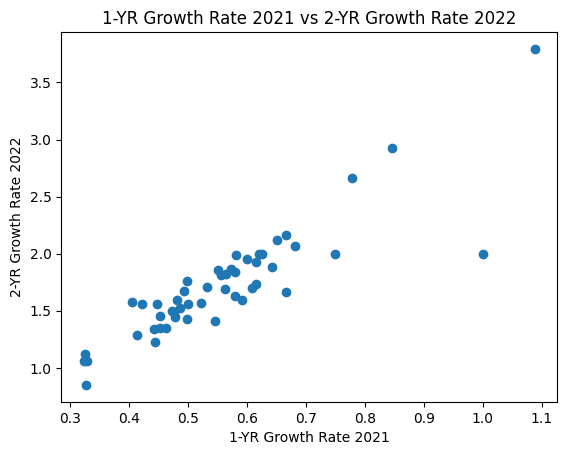

In [13]:
# plot 1 year growth rate 2022 vs 1 year growth rate 2021
X = data[['1-YR Growth Rate 2021']]
y = data['2-YR Growth Rate 2022']
plt.scatter(X, y)
plt.xlabel('1-YR Growth Rate 2021')
plt.ylabel('2-YR Growth Rate 2022')
plt.title('1-YR Growth Rate 2021 vs 2-YR Growth Rate 2022')
plt.show()


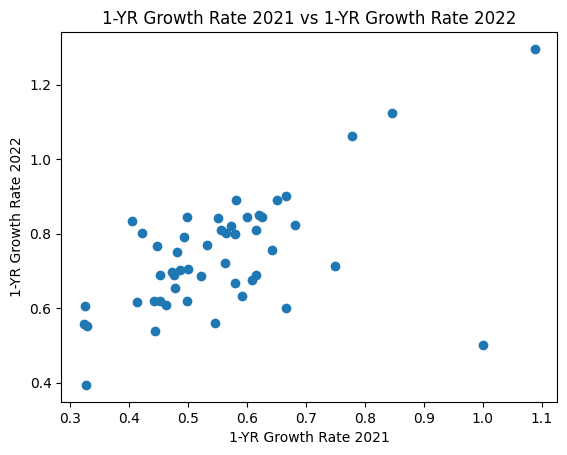

In [14]:
# plot 1 year growth rate 2022 vs 1 year growth rate 2021
X = data[['1-YR Growth Rate 2021']]
y = data['1-YR Growth Rate 2022']
plt.scatter(X, y)
plt.xlabel('1-YR Growth Rate 2021')
plt.ylabel('1-YR Growth Rate 2022')
plt.title('1-YR Growth Rate 2021 vs 1-YR Growth Rate 2022')
plt.show()


# additional experiments

In [15]:
#create data set using only the  values of X in x_vars
X = data[['Auto sales per capita 2023','Number of Evs per capita 2018','Number of Evs per capita 2019','Number of Evs per capita 2020','Number of EVs per capita 2021','Number of Evs per capita 2022','Auto sales 2023','Number of Evs 2018','Number of Evs 2019','Number of Evs 2020','Number of EVs 2021','Number of Evs 2022','Auto sales 2023','Number of Evs 2018','Number of Evs 2019','Number of Evs 2020','Number of EVs 2021','Number of Evs 2022','1-YR Growth Rate 2019','1-YR Growth Rate 2020','1-YR Growth Rate 2021']]

y = data[y_var[1]]

#Scale X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#Scale y
scaler = StandardScaler()
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))

#run linear regression
model, train_r2, test_r2 = run_linear_regression(X_scaled, y_scaled)

# Print coefficients of initial regression
print("Initial coefficients:", model.coef_)
print("Initial train R2:", train_r2)
print("Initial test R2:", test_r2)


Initial coefficients: [[ 1.32288731e+05  8.33432313e+04  7.91668675e+04 -4.66572786e+05
  -1.27002541e+05 -1.42896471e+05 -6.61443213e+04 -4.16724009e+04
  -3.95813263e+04  2.33285813e+05  6.34989946e+04  7.14497677e+04
  -6.61443213e+04 -4.16724009e+04 -3.95813263e+04  2.33285813e+05
   6.34989946e+04  7.14497677e+04 -1.74746178e-01  1.81383393e-01
   8.18905568e-01]]
Initial train R2: 0.9346295193078977
Initial test R2: 0.8096510877590165
